In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
#from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 10 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 3
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  60000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

best_Sil_score_c = []
Silhouette_sc_c = []

global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
#        TMP_w.extend(TMP_b) ##append 말고 더해야함..

#        TMP_w = np.array(TMP_w)
#        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    silhoutte_score_w = []
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    for clusters in range(6):       ####=>  이 범위 : 클러스터 갯수, 밑에 보면 cluster+2 있음 = 총 10개 => (0,11) = 10                                                       
        kmeans_model_w = KMeans(n_clusters=clusters+2)   # 0, 1은 silhouette 에 안먹힘  

        kmeans_model_w.fit(transformed)       #레이블 정의 

        silhoutte_score_w.append(silhouette_score(globals()['layer{}_W_tmp'.format(layer_index)], kmeans_model_w.labels_, metric='euclidean'))  

    num_clusters_for_w = np.argmax(silhoutte_score_w) 
    print(silhoutte_score_w, np.argmax(silhoutte_score_w), num_clusters_for_w+2)
    best_Sil_score_c.append(silhoutte_score_w[num_clusters_for_w])  # 처음에는 둘 다 넣어줌

    kmeans_model_w = KMeans(n_clusters=num_clusters_for_w+2)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters_for_w + 2  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 
    print("Layer : ", layer_index, "  클러스터 갯수 정해짐!  갯수 : ", globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)], num_clusters_for_w) 

    # ==========> 클러스터 갯수 정해짐

    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(num_clusters_for_w+2): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

transformed = 0
Silhouette_sc_c.append(best_Sil_score_c)
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4416 - accuracy: 0.8317
35/35 - 0s - loss: 0.5550 - accuracy: 0.7939
35/35 - 0s - loss: 0.5760 - accuracy: 0.8002
35/35 - 0s - loss: 0.5452 - accuracy: 0.8002
35/35 - 0s - loss: 0.4933 - accuracy: 0.8173
35/35 - 0s - loss: 0.5177 - accuracy: 0.8200
35/35 - 0s - loss: 0.5501 - accuracy: 0.7984
35/35 - 0s - loss: 0.5430 - accuracy: 0.8002
35/35 - 0s - loss: 0.5039 - accuracy: 0.8020
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time :  84.54395461082458 


[0.02313251, 0.030023852, 0.016135566, 0.012697084, 0.009474872, 0.007980463] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-7-15334861e92c>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


[0.008232856, 0.0074269166, 0.005852947, -0.0012127515, 0.0054858574, 0.0022335283] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-15334861e92c>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


[0.00802867, 0.0064851996, 0.00179548, 0.002182274, 0.0015820587, 0.0019545453] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-15334861e92c>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


[0.0079397755, 0.0034516694, 0.001905396, 0.0015060715, 0.00014193077, 0.0004199362] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-15334861e92c>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


[0.010921712, 0.010239127, 0.013262957, 0.011190351, 0.006584916, 0.004211711] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


<ipython-input-7-15334861e92c>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 = 복원추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        best_Sil_score_c = []
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []
        
        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
            
        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
#            TMP_w.extend(TMP_b) ##append 말고 더해야함..

#            TMP_w = np.array(TMP_w)
#            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        silhoutte_score_w = []
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        for clusters in range(4):       ####=>  이 범위 : 클러스터 갯수, 밑에 보면 cluster+2 있음 = 총 10개 => (0,11) = 10
            globals()['w_layer{}_label'.format(layer_index)] = 0
                                                            
            kmeans_model_w = KMeans(n_clusters=clusters+2)   # 0, 1은 silhouette 에 안먹힘  

            labelsss = kmeans_model_w.fit_predict(transformed)       #레이블 정의 

            silhoutte_score_w.append(silhouette_score(transformed, labelsss, metric='euclidean'))  
            
        num_clusters_for_w = np.argmax(silhoutte_score_w)  
        print(silhoutte_score_w, np.argmax(silhoutte_score_w), num_clusters_for_w+2)

        best_Sil_score_c.append(silhoutte_score_w[num_clusters_for_w])
 
        kmeans_model_w = KMeans(n_clusters=num_clusters_for_w+2)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters_for_w + 2  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        print("Layer : ", layer_index, "  클러스터 갯수 정해짐!  갯수 : ", globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)], num_clusters_for_w) ########################################################******************************************


        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(num_clusters_for_w+2): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

        
    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)
    Silhouette_sc_c.append(best_Sil_score_c)


    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")


1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.5374 - accuracy: 0.8128
35/35 - 0s - loss: 0.6470 - accuracy: 0.7507
35/35 - 0s - loss: 0.6603 - accuracy: 0.7624
35/35 - 0s - loss: 0.6184 - accuracy: 0.7750
35/35 - 0s - loss: 0.7244 - accuracy: 0.7471
35/35 - 0s - loss: 0.6027 - accuracy: 0.7795
35/35 - 0s - loss: 0.6161 - accuracy: 0.7615
35/35 - 0s - loss: 0.5500 - accuracy: 0.8002
35/35 - 0s - loss: 0.4810 - accuracy: 0.8137
------------    1  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  80.52437233924866 ---------------------------


[0.49790418, 0.7713375, 0.5708457, 0.29911897] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.36527213, 0.20523539, 0.21899275, 0.14642565] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.47862133, 0.06826119, 0.06491731, 0.060220778] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.60527474, 0.099599145, 0.104104795, 0.10437195] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.41641474, 0.6467209, 0.7567129, 0.46348852] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4667 - accuracy: 0.8191
35/35 - 0s - loss: 0.5073 - accuracy: 0.8173
35/35 - 0s - loss: 0.5960 - accuracy: 0.7642
35/35 - 0s - loss: 0.6683 - accuracy: 0.7390
35/35 - 0s - loss: 0.6162 - accuracy: 0.7768
35/35 - 0s - loss: 0.4794 - accuracy: 0.8299
35/35 - 0s - loss: 0.5533 - accuracy: 0.8101
35/35 - 0s - loss: 0.5247 - accuracy: 0.7948
35/35 - 0s - loss: 0.4972 - accuracy: 0.8344
------------    2  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  79.40250658988953 ---------------------------


[0.56113887, 0.8682214, 0.6086513, 0.59410673] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.5710609, 0.3085254, 0.33753702, 0.219426] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.5914604, 0.09629995, 0.09652363, 0.09936704] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6391441, 0.11723118, 0.14533295, 0.15234683] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

[0.43719062, 0.6628786, 0.77937675, 0.5182782] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!
3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3930 - accuracy: 0.8506
35/35 - 0s - loss: 0.5316 - accuracy: 0.8146
35/35 - 0s - loss: 0.6476 - accuracy: 0.7750
35/35 - 0s - loss: 0.4871 - accuracy: 0.8155
35/35 - 0s - loss: 0.4989 - accuracy: 0.8200
35/35 - 0s - loss: 0.5313 - accuracy: 0.8038
35/35 - 0s - loss: 0.5047 - accuracy: 0.8128
35/35 - 0s - loss: 0.4704 - accuracy: 0.8245
35/35 - 0s - loss: 0.4515 - accuracy: 0.8479
------------    3  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  78.11175799369812 ---------------------------


[0.583304, 0.90044975, 0.6423425, 0.6098807] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6826092, 0.3208891, 0.35256922, 0.21029545] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6333156, 0.077600405, 0.071792446, 0.0746319] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6544177, 0.113846935, 0.14737858, 0.1517945] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

[0.45064625, 0.6747093, 0.7935355, 0.5305658] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!
4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4013 - accuracy: 0.8623
35/35 - 0s - loss: 0.4742 - accuracy: 0.8110
35/35 - 0s - loss: 0.4410 - accuracy: 0.8335
35/35 - 0s - loss: 0.4357 - accuracy: 0.8371
35/35 - 0s - loss: 0.4626 - accuracy: 0.8299
35/35 - 0s - loss: 0.4581 - accuracy: 0.8254
35/35 - 0s - loss: 0.4369 - accuracy: 0.8380
35/35 - 0s - loss: 0.4970 - accuracy: 0.8218
35/35 - 0s - loss: 0.4556 - accuracy: 0.8236
------------    4  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  73.23411512374878 ---------------------------


[0.59761095, 0.9172076, 0.66988283, 0.6204964] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7372924, 0.3371949, 0.35632575, 0.20036037] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6606022, 0.077166, 0.079310335, 0.08232092] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.65658706, 0.09116808, 0.11907319, 0.12525517] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.45801103, 0.66891986, 0.7885258, 0.5519641] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================




<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

5  번째 global_epoch 데이터 랜덤하게 준비!!
5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4275 - accuracy: 0.8380
35/35 - 0s - loss: 0.4223 - accuracy: 0.8398
35/35 - 0s - loss: 0.4243 - accuracy: 0.8515
35/35 - 0s - loss: 0.4409 - accuracy: 0.8488
35/35 - 0s - loss: 0.4372 - accuracy: 0.8299
35/35 - 0s - loss: 0.4897 - accuracy: 0.8308
35/35 - 0s - loss: 0.4043 - accuracy: 0.8533
35/35 - 0s - loss: 0.4407 - accuracy: 0.8398
35/35 - 0s - loss: 0.4843 - accuracy: 0.8443
------------    5  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  73.3129026889801 ---------------------------


[0.6076293, 0.92544174, 0.6886526, 0.4837013] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.76925975, 0.3180288, 0.34094083, 0.17549941] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.67458904, 0.0662467, 0.06614085, 0.070964664] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.66066766, 0.049646094, 0.09203566, 0.08879377] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.4685376, 0.5285149, 0.7837701, 0.5506514] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3973 - accuracy: 0.8650
35/35 - 0s - loss: 0.4120 - accuracy: 0.8326
35/35 - 0s - loss: 0.4005 - accuracy: 0.8560
35/35 - 0s - loss: 0.4470 - accuracy: 0.8353
35/35 - 0s - loss: 0.4238 - accuracy: 0.8524
35/35 - 0s - loss: 0.3974 - accuracy: 0.8560
35/35 - 0s - loss: 0.4050 - accuracy: 0.8470
35/35 - 0s - loss: 0.4038 - accuracy: 0.8497
35/35 - 0s - loss: 0.4169 - accuracy: 0.8488
------------    6  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  76.9232337474823 ---------------------------


[0.61963165, 0.93622005, 0.6556514, 0.6288128] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.78835505, 0.3003849, 0.3206898, 0.1515786] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6839361, 0.056145046, 0.053618368, 0.044987448] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6701295, 0.03877969, 0.056797847, 0.07330797] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

[0.48401436, 0.54170036, 0.78836024, 0.5170482] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3802 - accuracy: 0.8569
35/35 - 0s - loss: 0.4302 - accuracy: 0.8560
35/35 - 0s - loss: 0.4146 - accuracy: 0.8443
35/35 - 0s - loss: 0.4142 - accuracy: 0.8533
35/35 - 0s - loss: 0.4115 - accuracy: 0.8524
35/35 - 0s - loss: 0.4101 - accuracy: 0.8497
35/35 - 0s - loss: 0.4448 - accuracy: 0.8344
35/35 - 0s - loss: 0.4438 - accuracy: 0.8533
35/35 - 0s - loss: 0.4143 - accuracy: 0.8569
------------    7  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  65.15919327735901 ---------------------------


[0.6202623, 0.93698704, 0.63528997, 0.63087976] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8004164, 0.27734458, 0.27508676, 0.11392726] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.69743705, 0.07450032, 0.044889916, 0.043609004] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.67703533, 0.044779737, 0.049138013, 0.05511145] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.49794164, 0.6631696, 0.7856855, 0.5250301] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4477 - accuracy: 0.8470
35/35 - 0s - loss: 0.3647 - accuracy: 0.8758
35/35 - 0s - loss: 0.3820 - accuracy: 0.8488
35/35 - 0s - loss: 0.3273 - accuracy: 0.8776
35/35 - 0s - loss: 0.3945 - accuracy: 0.8524
35/35 - 0s - loss: 0.3951 - accuracy: 0.8686
35/35 - 0s - loss: 0.3437 - accuracy: 0.8776
35/35 - 0s - loss: 0.3856 - accuracy: 0.8614
35/35 - 0s - loss: 0.3965 - accuracy: 0.8659
------------    8  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  57.77337908744812 ---------------------------


[0.6270355, 0.94125557, 0.73622954, 0.48126262] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.80290425, 0.26774645, 0.286523, 0.27416742] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.69913405, 0.046173126, 0.04254541, 0.034901697] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6783993, 0.031042943, 0.04009472, 0.04763885] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.51186246, 0.5605773, 0.7884098, 0.5279431] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3869 - accuracy: 0.8713
35/35 - 0s - loss: 0.4132 - accuracy: 0.8542
35/35 - 0s - loss: 0.3864 - accuracy: 0.8686
35/35 - 0s - loss: 0.3034 - accuracy: 0.8920
35/35 - 0s - loss: 0.3965 - accuracy: 0.8668
35/35 - 0s - loss: 0.3488 - accuracy: 0.8740
35/35 - 0s - loss: 0.4100 - accuracy: 0.8515
35/35 - 0s - loss: 0.4043 - accuracy: 0.8587
35/35 - 0s - loss: 0.3806 - accuracy: 0.8542
------------    9  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  58.75659894943237 ---------------------------


[0.6341437, 0.95044696, 0.7435307, 0.46396244] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8094615, 0.26457036, 0.27258408, 0.09686201] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7033106, 0.056314155, 0.04792239, 0.023356512] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.68098956, 0.05627163, 0.057557743, 0.028611295] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5246322, 0.6627503, 0.7848072, 0.50235766] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3597 - accuracy: 0.8929
35/35 - 0s - loss: 0.3897 - accuracy: 0.8659
35/35 - 0s - loss: 0.3331 - accuracy: 0.8875
35/35 - 0s - loss: 0.3617 - accuracy: 0.8677
35/35 - 0s - loss: 0.3872 - accuracy: 0.8614
35/35 - 0s - loss: 0.4136 - accuracy: 0.8569
35/35 - 0s - loss: 0.3515 - accuracy: 0.8758
35/35 - 0s - loss: 0.3614 - accuracy: 0.8740
35/35 - 0s - loss: 0.3648 - accuracy: 0.8713
------------    10  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  58.91555976867676 ---------------------------


[0.63755685, 0.9521277, 0.74466485, 0.45610535] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.816139, 0.2520234, 0.2644025, 0.08733353] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.71084934, 0.045971915, 0.044815596, 0.019367108] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6840264, 0.039469495, 0.029154591, 0.027741484] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5367335, 0.65845203, 0.77921295, 0.5288623] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3237 - accuracy: 0.8866
35/35 - 0s - loss: 0.3675 - accuracy: 0.8713
35/35 - 0s - loss: 0.3677 - accuracy: 0.8605
35/35 - 0s - loss: 0.4165 - accuracy: 0.8605
35/35 - 0s - loss: 0.3791 - accuracy: 0.8794
35/35 - 0s - loss: 0.3507 - accuracy: 0.8767
35/35 - 0s - loss: 0.3413 - accuracy: 0.8803
35/35 - 0s - loss: 0.3279 - accuracy: 0.8830
35/35 - 0s - loss: 0.3597 - accuracy: 0.8767
------------    11  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  59.79860877990723 ---------------------------


[0.6430976, 0.9576435, 0.748197, 0.438534] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8168514, 0.24504226, 0.24457611, 0.25146517] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7148387, 0.03606345, 0.017769128, 0.015777105] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.68763393, 0.044702467, 0.022639861, 0.019845638] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.547631, 0.65912205, 0.78138393, 0.49625635] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3511 - accuracy: 0.8875
35/35 - 0s - loss: 0.3568 - accuracy: 0.8578
35/35 - 0s - loss: 0.3318 - accuracy: 0.8812
35/35 - 0s - loss: 0.3747 - accuracy: 0.8659
35/35 - 0s - loss: 0.3282 - accuracy: 0.8884
35/35 - 0s - loss: 0.3494 - accuracy: 0.8803
35/35 - 0s - loss: 0.3449 - accuracy: 0.8794
35/35 - 0s - loss: 0.3365 - accuracy: 0.8812
35/35 - 0s - loss: 0.4100 - accuracy: 0.8614
------------    12  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  60.82397747039795 ---------------------------


[0.64343697, 0.9570923, 0.6687715, 0.458098] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8227298, 0.23670503, 0.23931116, 0.24573596] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.71996623, 0.036809616, 0.031017145, 0.019725239] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.69066143, 0.039493956, 0.022129945, 0.021581344] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.55891895, 0.6638558, 0.7867763, 0.50869244] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3744 - accuracy: 0.8884
35/35 - 0s - loss: 0.3561 - accuracy: 0.8776
35/35 - 0s - loss: 0.3761 - accuracy: 0.8560
35/35 - 0s - loss: 0.3313 - accuracy: 0.8839
35/35 - 0s - loss: 0.3402 - accuracy: 0.8848
35/35 - 0s - loss: 0.3481 - accuracy: 0.8803
35/35 - 0s - loss: 0.3101 - accuracy: 0.8893
35/35 - 0s - loss: 0.3898 - accuracy: 0.8650
35/35 - 0s - loss: 0.3104 - accuracy: 0.8830
------------    13  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  63.161524057388306 ---------------------------


[0.64791405, 0.96121746, 0.75019515, 0.4561826] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.82460535, 0.23059985, 0.24103403, 0.06153541] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.72492605, 0.03385159, 0.03513402, 0.011659748] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6924855, 0.048414692, 0.014808906, 0.015910558] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5683002, 0.66064876, 0.7840923, 0.49031985] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3783 - accuracy: 0.8731
35/35 - 0s - loss: 0.3670 - accuracy: 0.8677
35/35 - 0s - loss: 0.2799 - accuracy: 0.8947
35/35 - 0s - loss: 0.3994 - accuracy: 0.8632
35/35 - 0s - loss: 0.3095 - accuracy: 0.8866
35/35 - 0s - loss: 0.3292 - accuracy: 0.8857
35/35 - 0s - loss: 0.3188 - accuracy: 0.8920
35/35 - 0s - loss: 0.3320 - accuracy: 0.8929
35/35 - 0s - loss: 0.3423 - accuracy: 0.8821
------------    14  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  66.88560080528259 ---------------------------


[0.6481187, 0.9589744, 0.74952537, 0.4838872] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.82809424, 0.2280784, 0.23674062, 0.055729184] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7282851, 0.033319056, 0.02252982, 0.015038152] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6944508, 0.03951777, 0.029208444, 0.011132644] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5753849, 0.65806633, 0.78265005, 0.50964075] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3192 - accuracy: 0.8812
35/35 - 0s - loss: 0.3652 - accuracy: 0.8605
35/35 - 0s - loss: 0.3341 - accuracy: 0.8794
35/35 - 0s - loss: 0.3529 - accuracy: 0.8839
35/35 - 0s - loss: 0.3508 - accuracy: 0.8731
35/35 - 0s - loss: 0.3485 - accuracy: 0.8929
35/35 - 0s - loss: 0.3687 - accuracy: 0.8749
35/35 - 0s - loss: 0.3889 - accuracy: 0.8776
35/35 - 0s - loss: 0.3365 - accuracy: 0.8740
------------    15  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  65.14967560768127 ---------------------------


[0.6502703, 0.9620638, 0.7504018, 0.45254987] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.83229244, 0.23914045, 0.23706235, 0.053981345] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7318148, 0.034498326, 0.02710081, 0.019040499] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.6959348, 0.038447652, 0.00933892, 0.010333936] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5806262, 0.6594088, 0.78158617, 0.47162056] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4067 - accuracy: 0.8668
35/35 - 0s - loss: 0.3234 - accuracy: 0.8857
35/35 - 0s - loss: 0.2977 - accuracy: 0.8803
35/35 - 0s - loss: 0.3208 - accuracy: 0.8947
35/35 - 0s - loss: 0.3169 - accuracy: 0.8947
35/35 - 0s - loss: 0.3650 - accuracy: 0.8758
35/35 - 0s - loss: 0.3148 - accuracy: 0.8866
35/35 - 0s - loss: 0.3261 - accuracy: 0.8794
35/35 - 0s - loss: 0.3536 - accuracy: 0.8704
------------    16  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  68.80578088760376 ---------------------------


[0.65183735, 0.9619483, 0.6628854, 0.45093238] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8306472, 0.2368723, 0.22763395, 0.045119755] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7374013, 0.02877745, 0.012529153, 0.007756164] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.69885635, 0.031682406, 0.018706018, 0.010129355] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.58672005, 0.6614862, 0.7831721, 0.4729468] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4388 - accuracy: 0.8695
35/35 - 0s - loss: 0.3350 - accuracy: 0.8866
35/35 - 0s - loss: 0.3196 - accuracy: 0.8893
35/35 - 0s - loss: 0.3282 - accuracy: 0.8992
35/35 - 0s - loss: 0.3036 - accuracy: 0.8902
35/35 - 0s - loss: 0.3653 - accuracy: 0.8821
35/35 - 0s - loss: 0.3727 - accuracy: 0.8632
35/35 - 0s - loss: 0.3695 - accuracy: 0.8695
35/35 - 0s - loss: 0.3307 - accuracy: 0.8893
------------    17  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  79.85754346847534 ---------------------------


[0.65494967, 0.9661518, 0.7535807, 0.4597971] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.83643603, 0.22736841, 0.22806461, 0.22673093] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.73885673, 0.031696633, 0.021943428, 0.0095263915] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.70026493, 0.021058954, 0.014841597, 0.0110628735] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5938122, 0.66486406, 0.78454196, 0.4891156] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3698 - accuracy: 0.8785
35/35 - 0s - loss: 0.3519 - accuracy: 0.8794
35/35 - 0s - loss: 0.3588 - accuracy: 0.8776
35/35 - 0s - loss: 0.2943 - accuracy: 0.8803
35/35 - 0s - loss: 0.2976 - accuracy: 0.8893
35/35 - 0s - loss: 0.3268 - accuracy: 0.8875
35/35 - 0s - loss: 0.3820 - accuracy: 0.8722
35/35 - 0s - loss: 0.3629 - accuracy: 0.8758
35/35 - 0s - loss: 0.2642 - accuracy: 0.9109
------------    18  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  86.09642457962036 ---------------------------


[0.65337986, 0.9651499, 0.6629382, 0.44994614] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.83823204, 0.23261149, 0.04894201, 0.037477497] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7419988, 0.03078204, 0.017076757, 0.016882863] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7056253, 0.039829016, 0.014664855, 0.008183693] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.5984657, 0.6652305, 0.7830945, 0.4573704] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3507 - accuracy: 0.8794
35/35 - 0s - loss: 0.3460 - accuracy: 0.8902
35/35 - 0s - loss: 0.3645 - accuracy: 0.8731
35/35 - 0s - loss: 0.3318 - accuracy: 0.8974
35/35 - 0s - loss: 0.3526 - accuracy: 0.8830
35/35 - 0s - loss: 0.2629 - accuracy: 0.9073
35/35 - 0s - loss: 0.3442 - accuracy: 0.8839
35/35 - 0s - loss: 0.3202 - accuracy: 0.8974
35/35 - 0s - loss: 0.3214 - accuracy: 0.8884
------------    19  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  86.93634343147278 ---------------------------


[0.6547349, 0.9672177, 0.75403553, 0.45112908] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.83971286, 0.23082717, 0.04616638, 0.03790382] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.74412286, 0.05072988, 0.0282222, 0.014188321] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.70556957, 0.019553958, 0.012774413, 0.010208713] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6023737, 0.663924, 0.7792474, 0.48643976] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3817 - accuracy: 0.8794
35/35 - 0s - loss: 0.3735 - accuracy: 0.8785
35/35 - 0s - loss: 0.3619 - accuracy: 0.8830
35/35 - 0s - loss: 0.3894 - accuracy: 0.8767
35/35 - 0s - loss: 0.3277 - accuracy: 0.8875
35/35 - 0s - loss: 0.3336 - accuracy: 0.8875
35/35 - 0s - loss: 0.3449 - accuracy: 0.8857
35/35 - 0s - loss: 0.3489 - accuracy: 0.8740
35/35 - 0s - loss: 0.3191 - accuracy: 0.8902
------------    20  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  87.94783401489258 ---------------------------


[0.65446544, 0.96585625, 0.68059397, 0.4673158] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.84334075, 0.24048716, 0.05471362, 0.044735864] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7457055, 0.06021773, 0.034689683, 0.024569206] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.70872873, 0.030329611, 0.018716315, 0.01569286] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6072129, 0.66880685, 0.7838358, 0.4570384] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3229 - accuracy: 0.8911
35/35 - 0s - loss: 0.3224 - accuracy: 0.8857
35/35 - 0s - loss: 0.3498 - accuracy: 0.8848
35/35 - 0s - loss: 0.3046 - accuracy: 0.9109
35/35 - 0s - loss: 0.3670 - accuracy: 0.8866
35/35 - 0s - loss: 0.3564 - accuracy: 0.8866
35/35 - 0s - loss: 0.3606 - accuracy: 0.8731
35/35 - 0s - loss: 0.3272 - accuracy: 0.8821
35/35 - 0s - loss: 0.3352 - accuracy: 0.9019
------------    21  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  93.2518196105957 ---------------------------


[0.65525204, 0.9672631, 0.75398993, 0.44712025] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8460396, 0.23707849, 0.23097417, 0.04506264] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.751743, 0.023510888, 0.01532783, 0.017908858] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7125905, 0.03806359, 0.03500986, 0.007619312] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6077413, 0.6673366, 0.7824274, 0.50115925] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


22  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

22  번째 global_epoch 데이터 랜덤 준비완료!!


22  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.2870 - accuracy: 0.9046
35/35 - 0s - loss: 0.3296 - accuracy: 0.9019
35/35 - 0s - loss: 0.3460 - accuracy: 0.8947
35/35 - 0s - loss: 0.3469 - accuracy: 0.8893
35/35 - 0s - loss: 0.2867 - accuracy: 0.9037
35/35 - 0s - loss: 0.2872 - accuracy: 0.9127
35/35 - 0s - loss: 0.3499 - accuracy: 0.8929
35/35 - 0s - loss: 0.2863 - accuracy: 0.8992
35/35 - 0s - loss: 0.3083 - accuracy: 0.8947
------------    22  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.42152786254883 ---------------------------


[0.6546652, 0.9666744, 0.6761646, 0.46301332] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.84631693, 0.23134272, 0.039636146, 0.036137782] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75370336, 0.039209206, 0.015111542, 0.007837941] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7116859, 0.022185186, 0.008407535, 0.008736336] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6115725, 0.66942525, 0.78284883, 0.46141636] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


23  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3497 - accuracy: 0.8956
35/35 - 0s - loss: 0.3884 - accuracy: 0.8749
35/35 - 0s - loss: 0.3438 - accuracy: 0.8857
35/35 - 0s - loss: 0.4293 - accuracy: 0.8713
35/35 - 0s - loss: 0.3060 - accuracy: 0.9046
35/35 - 0s - loss: 0.3994 - accuracy: 0.8650
35/35 - 0s - loss: 0.2839 - accuracy: 0.9010
35/35 - 0s - loss: 0.3217 - accuracy: 0.8902
35/35 - 0s - loss: 0.3341 - accuracy: 0.8875
------------    23  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  94.01694917678833 ---------------------------


[0.65748906, 0.9689564, 0.6613679, 0.44731745] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8497659, 0.23267362, 0.22794482, 0.040805724] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7557814, 0.03304462, 0.013591806, 0.016022049] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7148509, 0.03458408, 0.022285983, 0.0072135404] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6159686, 0.6691285, 0.782018, 0.4688104] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


24  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

24  번째 global_epoch 데이터 랜덤 준비완료!!


24  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3302 - accuracy: 0.8848
35/35 - 0s - loss: 0.2681 - accuracy: 0.9199
35/35 - 0s - loss: 0.3204 - accuracy: 0.9019
35/35 - 0s - loss: 0.2745 - accuracy: 0.9028
35/35 - 0s - loss: 0.2674 - accuracy: 0.8992
35/35 - 0s - loss: 0.3589 - accuracy: 0.8938
35/35 - 0s - loss: 0.3207 - accuracy: 0.8983
35/35 - 0s - loss: 0.3479 - accuracy: 0.8776
35/35 - 0s - loss: 0.3546 - accuracy: 0.8587
------------    24  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  96.51129722595215 ---------------------------


[0.65901047, 0.97124356, 0.7575569, 0.45292985] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.853228, 0.22174168, 0.03123484, 0.036378615] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75820386, 0.03847404, 0.019834656, 0.013176199] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.71903586, 0.02731612, 0.023348449, 0.0034392849] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6245121, 0.6764733, 0.7898924, 0.4682938] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


25  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

25  번째 global_epoch 데이터 랜덤 준비완료!!


25  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3383 - accuracy: 0.8929
35/35 - 0s - loss: 0.3593 - accuracy: 0.8911
35/35 - 0s - loss: 0.3649 - accuracy: 0.8911
35/35 - 0s - loss: 0.2959 - accuracy: 0.9046
35/35 - 0s - loss: 0.3209 - accuracy: 0.9055
35/35 - 0s - loss: 0.3336 - accuracy: 0.8947
35/35 - 0s - loss: 0.2817 - accuracy: 0.8947
35/35 - 0s - loss: 0.3735 - accuracy: 0.8830
35/35 - 0s - loss: 0.3176 - accuracy: 0.8812
------------    25  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  99.24607825279236 ---------------------------


[0.6589578, 0.9707913, 0.7567494, 0.44192573] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8533937, 0.22539313, 0.03159184, 0.02814582] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7585101, 0.049925435, 0.02626295, 0.006637191] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7191236, 0.03132242, 0.01830732, 0.007954301] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.628161, 0.6782954, 0.79010993, 0.45354667] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3942 - accuracy: 0.8785
35/35 - 0s - loss: 0.3178 - accuracy: 0.8929
35/35 - 0s - loss: 0.3423 - accuracy: 0.8965
35/35 - 0s - loss: 0.3305 - accuracy: 0.8830
35/35 - 0s - loss: 0.3450 - accuracy: 0.8920
35/35 - 0s - loss: 0.3997 - accuracy: 0.9010
35/35 - 0s - loss: 0.3293 - accuracy: 0.8974
35/35 - 0s - loss: 0.3372 - accuracy: 0.8857
35/35 - 0s - loss: 0.2721 - accuracy: 0.9154
------------    26  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  107.16577196121216 ---------------------------


[0.65915054, 0.97164166, 0.75667137, 0.437923] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8553644, 0.22076038, 0.02819062, 0.03337092] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.76154256, 0.04089965, 0.024009198, 0.01445115] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.72119987, 0.034584194, 0.0066726166, 0.0046066428] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.63107604, 0.6766282, 0.7881579, 0.46956265] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


27  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

27  번째 global_epoch 데이터 랜덤 준비완료!!


27  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.2846 - accuracy: 0.9046
35/35 - 0s - loss: 0.3319 - accuracy: 0.8857
35/35 - 0s - loss: 0.3685 - accuracy: 0.8929
35/35 - 0s - loss: 0.2778 - accuracy: 0.9019
35/35 - 0s - loss: 0.3802 - accuracy: 0.8794
35/35 - 0s - loss: 0.3061 - accuracy: 0.9100
35/35 - 0s - loss: 0.3309 - accuracy: 0.8857
35/35 - 0s - loss: 0.3341 - accuracy: 0.8938
35/35 - 0s - loss: 0.3257 - accuracy: 0.8965
------------    27  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  109.27625894546509 ---------------------------


[0.65870756, 0.9702921, 0.6749904, 0.46084702] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.85866195, 0.67006373, 0.025672082, 0.025245186] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7648543, 0.055047646, 0.01952704, 0.018995699] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.725582, 0.005593997, 0.005384721, 0.0072874534] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6340989, 0.68231845, 0.7915989, 0.5882607] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3425 - accuracy: 0.8911
35/35 - 0s - loss: 0.3569 - accuracy: 0.8893
35/35 - 0s - loss: 0.3275 - accuracy: 0.8938
35/35 - 0s - loss: 0.3658 - accuracy: 0.8947
35/35 - 0s - loss: 0.3273 - accuracy: 0.8938
35/35 - 0s - loss: 0.3906 - accuracy: 0.8920
35/35 - 0s - loss: 0.3294 - accuracy: 0.8884
35/35 - 0s - loss: 0.3250 - accuracy: 0.8947
35/35 - 0s - loss: 0.3440 - accuracy: 0.8839
------------    28  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  109.05928802490234 ---------------------------


[0.65906334, 0.9705056, 0.658769, 0.44417673] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8576374, 0.22271064, 0.03375931, 0.029772827] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7666172, 0.03834445, 0.016645217, 0.014478003] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.72819906, 0.022919964, 0.015952587, 0.008563606] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.63692874, 0.68121505, 0.7905389, 0.4737499] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


29  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

29  번째 global_epoch 데이터 랜덤 준비완료!!


29  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3363 - accuracy: 0.8956
35/35 - 0s - loss: 0.3478 - accuracy: 0.8857
35/35 - 0s - loss: 0.3354 - accuracy: 0.8965
35/35 - 0s - loss: 0.3317 - accuracy: 0.8947
35/35 - 0s - loss: 0.2700 - accuracy: 0.9055
35/35 - 0s - loss: 0.3454 - accuracy: 0.8956
35/35 - 0s - loss: 0.3775 - accuracy: 0.8911
35/35 - 0s - loss: 0.3402 - accuracy: 0.8902
35/35 - 0s - loss: 0.3311 - accuracy: 0.8893
------------    29  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  115.29926443099976 ---------------------------


[0.65851676, 0.97082627, 0.66021985, 0.64823765] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8590238, 0.22142223, 0.031771176, 0.022687217] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.768095, 0.021720435, 0.011206983, 0.012238807] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7294246, 0.02934185, 0.018759124, 0.008848673] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6398449, 0.6854943, 0.7915553, 0.58915496] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


30  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

30  번째 global_epoch 데이터 랜덤 준비완료!!


30  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3716 - accuracy: 0.8947
35/35 - 0s - loss: 0.3481 - accuracy: 0.8992
35/35 - 0s - loss: 0.3346 - accuracy: 0.9001
35/35 - 0s - loss: 0.3411 - accuracy: 0.8965
35/35 - 0s - loss: 0.3093 - accuracy: 0.9064
35/35 - 0s - loss: 0.3614 - accuracy: 0.8956
35/35 - 0s - loss: 0.3509 - accuracy: 0.8893
35/35 - 0s - loss: 0.3308 - accuracy: 0.9055
35/35 - 0s - loss: 0.2950 - accuracy: 0.9037
------------    30  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  126.99537634849548 ---------------------------


[0.65959847, 0.97069657, 0.6628207, 0.44845077] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.85980743, 0.21412283, 0.024267873, 0.016686525] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.77060777, 0.039059, 0.021992188, 0.005167266] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.73313516, 0.039337147, 0.034957394, 0.008274618] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.64145195, 0.6846617, 0.7905849, 0.5887383] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


31  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

31  번째 global_epoch 데이터 랜덤 준비완료!!


31  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3280 - accuracy: 0.8929
35/35 - 0s - loss: 0.3661 - accuracy: 0.8839
35/35 - 0s - loss: 0.3762 - accuracy: 0.9091
35/35 - 0s - loss: 0.3031 - accuracy: 0.9118
35/35 - 0s - loss: 0.3460 - accuracy: 0.9001
35/35 - 0s - loss: 0.3693 - accuracy: 0.8839
35/35 - 0s - loss: 0.3307 - accuracy: 0.8911
35/35 - 0s - loss: 0.3160 - accuracy: 0.8884
35/35 - 0s - loss: 0.3486 - accuracy: 0.8956
------------    31  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  127.60636806488037 ---------------------------


[0.6602114, 0.9714665, 0.69130635, 0.47623697] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8640393, 0.6736343, 0.022355102, 0.024211928] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.77264017, 0.041069582, 0.0151348645, 0.015825493] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7345987, 0.029845903, 0.026818585, 0.011987314] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6459515, 0.6896495, 0.7958258, 0.5927913] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

32  번째 global_epoch 데이터 랜덤 준비완료!!


32  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3466 - accuracy: 0.8875
35/35 - 0s - loss: 0.3403 - accuracy: 0.9055
35/35 - 0s - loss: 0.3634 - accuracy: 0.8866
35/35 - 0s - loss: 0.2995 - accuracy: 0.9010
35/35 - 0s - loss: 0.4117 - accuracy: 0.8893
35/35 - 0s - loss: 0.3281 - accuracy: 0.8920
35/35 - 0s - loss: 0.3423 - accuracy: 0.8956
35/35 - 0s - loss: 0.3607 - accuracy: 0.8884
35/35 - 0s - loss: 0.3520 - accuracy: 0.8992
------------    32  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  134.15663313865662 ---------------------------


[0.6607173, 0.9718794, 0.75669795, 0.44513342] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.86315376, 0.213153, 0.019669132, 0.02064384] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7737948, 0.02816695, 0.02532143, 0.011302471] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7382717, 0.024799122, 0.0107648885, 0.0131921265] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6495528, 0.6925023, 0.79712003, 0.59255695] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


33  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

33  번째 global_epoch 데이터 랜덤 준비완료!!


33  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3237 - accuracy: 0.8893
35/35 - 0s - loss: 0.3062 - accuracy: 0.8992
35/35 - 0s - loss: 0.2984 - accuracy: 0.9001
35/35 - 0s - loss: 0.3668 - accuracy: 0.8983
35/35 - 0s - loss: 0.3884 - accuracy: 0.9019
35/35 - 0s - loss: 0.3755 - accuracy: 0.8956
35/35 - 0s - loss: 0.3042 - accuracy: 0.9091
35/35 - 0s - loss: 0.3340 - accuracy: 0.8938
35/35 - 0s - loss: 0.3000 - accuracy: 0.9127
------------    33  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  129.95020127296448 ---------------------------


[0.6614468, 0.9732741, 0.6516467, 0.65028036] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8669067, 0.6758254, 0.03151842, 0.017017387] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.77427906, 0.031170053, 0.024670504, 0.00811391] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.73716134, 0.030423215, 0.025602154, 0.0061259693] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6511476, 0.68988234, 0.7923877, 0.44734213] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3698 - accuracy: 0.8947
35/35 - 0s - loss: 0.3697 - accuracy: 0.8965
35/35 - 0s - loss: 0.3809 - accuracy: 0.8992
35/35 - 0s - loss: 0.3885 - accuracy: 0.8902
35/35 - 0s - loss: 0.3882 - accuracy: 0.8974
35/35 - 0s - loss: 0.3238 - accuracy: 0.9046
35/35 - 0s - loss: 0.3485 - accuracy: 0.8911
35/35 - 0s - loss: 0.3137 - accuracy: 0.9055
35/35 - 0s - loss: 0.3205 - accuracy: 0.8956
------------    34  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  140.2084424495697 ---------------------------


[0.6615293, 0.9731156, 0.6718412, 0.6503662] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.86651444, 0.67545813, 0.019552115, 0.020714663] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.77551854, 0.042052824, 0.034342766, 0.012472793] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.73884845, 0.038125165, 0.013042377, 0.012970779] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6512973, 0.69004077, 0.7911727, 0.4584929] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


35  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

35  번째 global_epoch 데이터 랜덤 준비완료!!


35  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3996 - accuracy: 0.8866
35/35 - 0s - loss: 0.3637 - accuracy: 0.8938
35/35 - 0s - loss: 0.3152 - accuracy: 0.9172
35/35 - 0s - loss: 0.3723 - accuracy: 0.8902
35/35 - 0s - loss: 0.3202 - accuracy: 0.9172
35/35 - 0s - loss: 0.3569 - accuracy: 0.8983
35/35 - 0s - loss: 0.2813 - accuracy: 0.9064
35/35 - 0s - loss: 0.3656 - accuracy: 0.8974
35/35 - 0s - loss: 0.3477 - accuracy: 0.8839
------------    35  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  146.80292749404907 ---------------------------


[0.6605947, 0.97232085, 0.65610915, 0.44120595] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8668169, 0.22219676, 0.031143503, 0.027852962] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.777853, 0.029137982, 0.028601157, 0.009826622] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7418109, 0.034750644, 0.027912531, 0.00896383] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6553444, 0.6930369, 0.7936211, 0.47202075] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


36  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3353 - accuracy: 0.9019
35/35 - 0s - loss: 0.3386 - accuracy: 0.8857
35/35 - 0s - loss: 0.3509 - accuracy: 0.8938
35/35 - 0s - loss: 0.3956 - accuracy: 0.8884
35/35 - 0s - loss: 0.3436 - accuracy: 0.9064
35/35 - 0s - loss: 0.4515 - accuracy: 0.8578
35/35 - 0s - loss: 0.3258 - accuracy: 0.9010
35/35 - 0s - loss: 0.2925 - accuracy: 0.8947
35/35 - 0s - loss: 0.3544 - accuracy: 0.8947
------------    36  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  150.62878108024597 ---------------------------


[0.66013414, 0.9710534, 0.7566786, 0.4475814] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.86959296, 0.6781037, 0.02101259, 0.018071022] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7804367, 0.024893356, 0.023196822, 0.007998821] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.74223226, 0.029006902, 0.026954021, 0.0070694163] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6573786, 0.69595885, 0.7960378, 0.59155506] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


37  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

37  번째 global_epoch 데이터 랜덤 준비완료!!


37  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3620 - accuracy: 0.8938
35/35 - 0s - loss: 0.3516 - accuracy: 0.8983
35/35 - 0s - loss: 0.3351 - accuracy: 0.9127
35/35 - 0s - loss: 0.3781 - accuracy: 0.8965
35/35 - 0s - loss: 0.3591 - accuracy: 0.8938
35/35 - 0s - loss: 0.3512 - accuracy: 0.9046
35/35 - 0s - loss: 0.3580 - accuracy: 0.9073
35/35 - 0s - loss: 0.3189 - accuracy: 0.8947
35/35 - 0s - loss: 0.3863 - accuracy: 0.8902
------------    37  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  156.4463849067688 ---------------------------


[0.6603334, 0.9741812, 0.6713936, 0.45529228] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.87156844, 0.67924774, 0.02639649, 0.020931708] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.78083336, 0.031437177, 0.014646005, 0.010755729] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.744558, 0.04106339, 0.018342154, 0.007765258] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6587833, 0.6944058, 0.7954279, 0.47565964] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


38  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

38  번째 global_epoch 데이터 랜덤 준비완료!!


38  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3765 - accuracy: 0.8920
35/35 - 0s - loss: 0.3336 - accuracy: 0.9109
35/35 - 0s - loss: 0.3753 - accuracy: 0.8983
35/35 - 0s - loss: 0.3978 - accuracy: 0.8893
35/35 - 0s - loss: 0.3980 - accuracy: 0.8866
35/35 - 0s - loss: 0.2886 - accuracy: 0.9127
35/35 - 0s - loss: 0.2957 - accuracy: 0.9100
35/35 - 0s - loss: 0.3678 - accuracy: 0.8947
35/35 - 0s - loss: 0.3414 - accuracy: 0.8956
------------    38  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  165.41347360610962 ---------------------------


[0.6608448, 0.97409046, 0.6620467, 0.44608504] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.87108666, 0.21845019, 0.026239809, 0.016140634] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7828186, 0.02373831, 0.012181044, 0.0150378905] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7460362, 0.032430165, 0.0131959515, 0.0053766156] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6630324, 0.6974733, 0.79755807, 0.4573264] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


39  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3286 - accuracy: 0.9001
35/35 - 0s - loss: 0.3733 - accuracy: 0.8929
35/35 - 0s - loss: 0.3426 - accuracy: 0.9028
35/35 - 0s - loss: 0.3944 - accuracy: 0.8929
35/35 - 0s - loss: 0.3447 - accuracy: 0.9001
35/35 - 0s - loss: 0.3600 - accuracy: 0.9019
35/35 - 0s - loss: 0.3995 - accuracy: 0.8812
35/35 - 0s - loss: 0.3191 - accuracy: 0.9010
35/35 - 0s - loss: 0.3688 - accuracy: 0.8947
------------    39  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  163.7563829421997 ---------------------------


[0.6602197, 0.97386384, 0.66886276, 0.65058243] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.87206, 0.68037003, 0.025799232, 0.016351843] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7826282, 0.03122621, 0.030850371, 0.008935444] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.74560124, 0.044379927, 0.020594688, 0.005653086] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6635816, 0.69528824, 0.7956493, 0.5914753] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


40  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3938 - accuracy: 0.8911
35/35 - 0s - loss: 0.4175 - accuracy: 0.8920
35/35 - 0s - loss: 0.4091 - accuracy: 0.8965
35/35 - 0s - loss: 0.3668 - accuracy: 0.8965
35/35 - 0s - loss: 0.3332 - accuracy: 0.8974
35/35 - 0s - loss: 0.4115 - accuracy: 0.8965
35/35 - 0s - loss: 0.3175 - accuracy: 0.9073
35/35 - 0s - loss: 0.3770 - accuracy: 0.8830
35/35 - 0s - loss: 0.3208 - accuracy: 0.9217
------------    40  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  165.2769260406494 ---------------------------


[0.6606766, 0.9736222, 0.6957157, 0.48045] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8731996, 0.22221078, 0.029499114, 0.025742445] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7857448, 0.034256496, 0.020250322, 0.003990231] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7477318, 0.026879855, 0.026018586, 0.009177502] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6669214, 0.6967566, 0.7971169, 0.5913485] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


41  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

41  번째 global_epoch 데이터 랜덤 준비완료!!


41  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4019 - accuracy: 0.8938
35/35 - 0s - loss: 0.2961 - accuracy: 0.9145
35/35 - 0s - loss: 0.3862 - accuracy: 0.9001
35/35 - 0s - loss: 0.4266 - accuracy: 0.8803
35/35 - 0s - loss: 0.4053 - accuracy: 0.9091
35/35 - 0s - loss: 0.4334 - accuracy: 0.8947
35/35 - 0s - loss: 0.2926 - accuracy: 0.9109
35/35 - 0s - loss: 0.3161 - accuracy: 0.9109
35/35 - 0s - loss: 0.3805 - accuracy: 0.8920
------------    41  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  172.30339193344116 ---------------------------


[0.6611378, 0.9731651, 0.6552438, 0.4400967] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8749364, 0.6819916, 0.032848507, 0.025367051] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.787122, 0.03218411, 0.031523213, 0.016368108] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7514839, 0.04299277, 0.028537976, 0.01499231] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.669513, 0.6993054, 0.79930604, 0.59315133] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


42  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

42  번째 global_epoch 데이터 랜덤 준비완료!!


42  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4230 - accuracy: 0.8821
35/35 - 0s - loss: 0.3711 - accuracy: 0.8965
35/35 - 0s - loss: 0.3037 - accuracy: 0.9190
35/35 - 0s - loss: 0.4090 - accuracy: 0.8875
35/35 - 0s - loss: 0.3422 - accuracy: 0.9010
35/35 - 0s - loss: 0.4341 - accuracy: 0.8929
35/35 - 0s - loss: 0.3573 - accuracy: 0.8902
35/35 - 0s - loss: 0.3347 - accuracy: 0.8974
35/35 - 0s - loss: 0.2592 - accuracy: 0.9235
------------    42  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  178.3596875667572 ---------------------------


[0.6625329, 0.97315884, 0.75814617, 0.4519201] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8766275, 0.22800551, 0.03439282, 0.017043445] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7869437, 0.028480053, 0.003982931, 0.005603262] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7506985, 0.040855117, 0.027703172, 0.0028342218] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6701836, 0.6984605, 0.7986958, 0.59283805] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


43  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

43  번째 global_epoch 데이터 랜덤 준비완료!!


43  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4264 - accuracy: 0.8929
35/35 - 0s - loss: 0.3299 - accuracy: 0.9064
35/35 - 0s - loss: 0.4087 - accuracy: 0.9073
35/35 - 0s - loss: 0.3323 - accuracy: 0.9073
35/35 - 1s - loss: 0.4308 - accuracy: 0.9001
35/35 - 0s - loss: 0.3972 - accuracy: 0.9091
35/35 - 0s - loss: 0.2943 - accuracy: 0.9271
35/35 - 0s - loss: 0.3283 - accuracy: 0.8992
35/35 - 0s - loss: 0.3901 - accuracy: 0.8992
------------    43  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  184.22817182540894 ---------------------------


[0.66385055, 0.9742937, 0.7590892, 0.43522188] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8766466, 0.6837046, 0.032374457, 0.025073433] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7883628, 0.01967429, 0.008601853, 0.013206893] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7523161, 0.043096032, 0.02821417, 0.0082510365] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.67035174, 0.69493073, 0.79450864, 0.44913012] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


44  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

44  번째 global_epoch 데이터 랜덤 준비완료!!


44  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4149 - accuracy: 0.8695
35/35 - 0s - loss: 0.3597 - accuracy: 0.9019
35/35 - 1s - loss: 0.3859 - accuracy: 0.9055
35/35 - 1s - loss: 0.3887 - accuracy: 0.9046
35/35 - 1s - loss: 0.4091 - accuracy: 0.8893
35/35 - 1s - loss: 0.3729 - accuracy: 0.8902
35/35 - 1s - loss: 0.3642 - accuracy: 0.9109
35/35 - 1s - loss: 0.3106 - accuracy: 0.9019
35/35 - 1s - loss: 0.4483 - accuracy: 0.8812
------------    44  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  190.58099579811096 ---------------------------


[0.6638816, 0.97448295, 0.67874455, 0.4630828] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8793649, 0.21471964, 0.2227695, 0.028391778] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7893141, 0.028685562, 0.025127161, 0.014056113] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75180924, 0.02866412, 0.024181407, 0.005518063] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6709011, 0.69224054, 0.7906086, 0.4533126] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


45  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

45  번째 global_epoch 데이터 랜덤 준비완료!!


45  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 1s - loss: 0.3912 - accuracy: 0.8974
35/35 - 1s - loss: 0.3660 - accuracy: 0.8902
35/35 - 1s - loss: 0.4714 - accuracy: 0.8956
35/35 - 1s - loss: 0.3529 - accuracy: 0.8992
35/35 - 1s - loss: 0.3820 - accuracy: 0.8983
35/35 - 1s - loss: 0.4489 - accuracy: 0.8884
35/35 - 1s - loss: 0.3649 - accuracy: 0.9010
35/35 - 1s - loss: 0.3766 - accuracy: 0.9028
35/35 - 1s - loss: 0.3676 - accuracy: 0.8938
------------    45  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  195.4823842048645 ---------------------------


[0.6654246, 0.9760433, 0.76037955, 0.43949685] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8775615, 0.2238774, 0.029976746, 0.02311186] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7908316, 0.013629106, 0.0059828446, 0.011392797] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75326544, 0.045774736, 0.012664165, 0.01379573] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6725963, 0.6947321, 0.79184574, 0.5860153] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


46  번째 global_epoch 데이터 랜덤하게 준비!!

<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals


46  번째 global_epoch 데이터 랜덤 준비완료!!


46  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 1s - loss: 0.3775 - accuracy: 0.8992
35/35 - 1s - loss: 0.3890 - accuracy: 0.9082
35/35 - 1s - loss: 0.3479 - accuracy: 0.9028
35/35 - 1s - loss: 0.3735 - accuracy: 0.8956
35/35 - 1s - loss: 0.3538 - accuracy: 0.9091
35/35 - 1s - loss: 0.2934 - accuracy: 0.9208
35/35 - 1s - loss: 0.3608 - accuracy: 0.8974
35/35 - 1s - loss: 0.3714 - accuracy: 0.8920
35/35 - 1s - loss: 0.3702 - accuracy: 0.9055
------------    46  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  199.09892177581787 ---------------------------


[0.6648183, 0.9741444, 0.75902814, 0.44033158] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8780401, 0.22132057, 0.2191511, 0.21951649] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7920208, 0.01615658, 0.017693749, 0.009259488] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75544536, 0.045373935, 0.0060566077, 0.007603474] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.67466515, 0.6952516, 0.7927655, 0.587005] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 1s - loss: 0.3449 - accuracy: 0.9010
35/35 - 1s - loss: 0.4328 - accuracy: 0.8875
35/35 - 1s - loss: 0.3620 - accuracy: 0.9091
35/35 - 1s - loss: 0.4521 - accuracy: 0.8848
35/35 - 1s - loss: 0.3792 - accuracy: 0.8902
35/35 - 1s - loss: 0.4101 - accuracy: 0.9046
35/35 - 1s - loss: 0.3471 - accuracy: 0.9010
35/35 - 1s - loss: 0.3577 - accuracy: 0.8983
35/35 - 1s - loss: 0.3804 - accuracy: 0.9001
------------    47  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  206.5007767677307 ---------------------------


[0.66561633, 0.97490716, 0.6707163, 0.6511383] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8800191, 0.22727415, 0.21896274, 0.024300836] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7925351, 0.023670983, 0.01717846, 0.01622427] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75684917, 0.031724922, 0.031157596, 0.012877314] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6748252, 0.69696546, 0.7949163, 0.46242535] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


48  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

48  번째 global_epoch 데이터 랜덤 준비완료!!


48  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 1s - loss: 0.4052 - accuracy: 0.8893
35/35 - 1s - loss: 0.4213 - accuracy: 0.8947
35/35 - 1s - loss: 0.4286 - accuracy: 0.8920
35/35 - 1s - loss: 0.4219 - accuracy: 0.9019
35/35 - 1s - loss: 0.4064 - accuracy: 0.8983
35/35 - 1s - loss: 0.3969 - accuracy: 0.8956
35/35 - 1s - loss: 0.3705 - accuracy: 0.8938
35/35 - 1s - loss: 0.4183 - accuracy: 0.9019
35/35 - 1s - loss: 0.3577 - accuracy: 0.9055
------------    48  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  205.82530212402344 ---------------------------


[0.66629356, 0.9749478, 0.75944835, 0.4572968] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.88225275, 0.22344783, 0.20665643, 0.019879017] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.79362446, 0.029570274, 0.022693781, 0.020925917] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7573544, 0.023357661, 0.02072105, 0.013047962] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.675559, 0.6968344, 0.7918956, 0.5869977] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================


49  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

49  번째 global_epoch 데이터 랜덤 준비완료!!


49  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 1s - loss: 0.3893 - accuracy: 0.8830
35/35 - 1s - loss: 0.5093 - accuracy: 0.9001
35/35 - 1s - loss: 0.3872 - accuracy: 0.9019
35/35 - 1s - loss: 0.4002 - accuracy: 0.9118
35/35 - 1s - loss: 0.4237 - accuracy: 0.8965
35/35 - 1s - loss: 0.3919 - accuracy: 0.9136
35/35 - 1s - loss: 0.4695 - accuracy: 0.9001
35/35 - 1s - loss: 0.3792 - accuracy: 0.8965
35/35 - 1s - loss: 0.4153 - accuracy: 0.8956
------------    49  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  212.56647205352783 ---------------------------


[0.6675867, 0.9763246, 0.67455786, 0.4584852] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8836332, 0.22880608, 0.03337129, 0.030019386] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.79684615, 0.021024918, 0.019906439, 0.006911443] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.76081824, 0.036130764, 0.011578526, 0.0070112785] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.67826056, 0.70203084, 0.79681516, 0.5906392] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================




<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

50  번째 global_epoch 데이터 랜덤하게 준비!!
50  번째 global_epoch 데이터 랜덤 준비완료!!


50  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 1s - loss: 0.3893 - accuracy: 0.8839
35/35 - 1s - loss: 0.3926 - accuracy: 0.9082
35/35 - 1s - loss: 0.3168 - accuracy: 0.9271
35/35 - 1s - loss: 0.4047 - accuracy: 0.8911
35/35 - 1s - loss: 0.4568 - accuracy: 0.8911
35/35 - 1s - loss: 0.4962 - accuracy: 0.8839
35/35 - 1s - loss: 0.3923 - accuracy: 0.9064
35/35 - 1s - loss: 0.4138 - accuracy: 0.8920
35/35 - 1s - loss: 0.4671 - accuracy: 0.8965
------------    50  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  217.97181057929993 ---------------------------


[0.6660035, 0.9761723, 0.6709115, 0.45477384] 1 3
Layer :  0   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.8820274, 0.22914608, 0.034111924, 0.01833187] 0 2
Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.7950987, 0.019001057, 0.0056355554, 0.0072946656] 0 2
Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


[0.75898385, 0.03508443, 0.026239676, 0.004036603] 0 2
Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0
[0.6771905, 0.6990411, 0.7924389, 0.58840823] 2 4
Layer :  7   클러스터 갯수 정해짐!  갯수 :  4 2


====================================================== One Global Epoch =====================================================================




<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-29702e637bed>:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

In [11]:
#클러스터 레이어들끼리 weight 확이 => 똑같지는 않은지 확인

In [15]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  22 32 28
Layer 2  ==> label 0, 1, 2 갯수 :  81 18 0
Layer 4  ==> label 0, 1, 2 갯수 :  74 25 0
Layer 6  ==> label 0, 1, 2 갯수 :  74 25 0
Layer 7  ==> label 0, 1, 2 갯수 :  50 49 0


Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.0018432966, 0.0034097375, 0.0054637003, 0.007769611, 0.010043032, 0.012391362, 0.014593247, 0.016626753, 0.018456297, 0.020494219]
[0.0013204834, 0.002347163, 0.0033841925, 0.0042766067, 0.004977644, 0.005577844, 0.006123375, 0.0066373907, 0.0071072034, 0.00760193]
[0.0007788569, 0.0011242556, 0.0014364126, 0.0017475759, 0.0020623303, 0.0023606336, 0.0026605064, 0.0029475247, 0.003252206, 0.0035312304]
[0.001050043, 0.0011900803, 0.0013330411, 0.0014986959, 0.0016871162, 0.001885297, 0.0021060733, 0.0023447322, 0.0025576805, 0.0028052698]
[0.0031425715, 0.0037864968, 0.0046693026, 0.005801505, 0.0071008266, 0.008594425, 0.010325099, 0.0122347325, 0.014425918, 0.016740184]

Var Accumulate Bias
--------------------------------------
[9.680945e-05, 0.00020641758, 0.00044105024, 0.00073110114

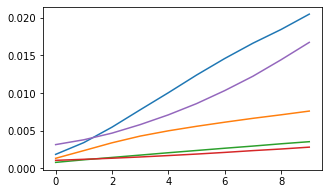

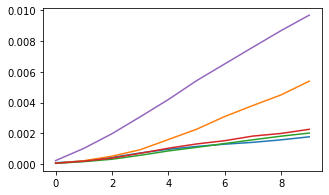

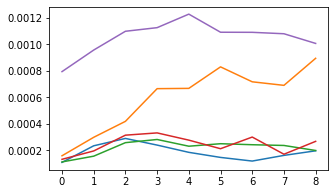

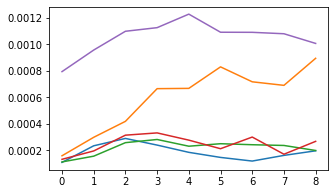

In [17]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]
        sumss_b = sumss_b/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.027336027, 0.02063378, 0.016476614, 0.01439096, 0.012064031, 0.011504661, 0.009969794, 0.009328123, 0.008704437, 0.008108985, 0.007719043, 0.0068032346, 0.0064485013, 0.00618607, 0.0063256235, 0.0054409173, 0.005237857, 0.00566138, 0.005061942, 0.004660473, 0.005163243, 0.0048174793, 0.004831723, 0.0049470486, 0.004484628, 0.004605591, 0.0045405184, 0.004445784, 0.0043084146, 0.004461361, 0.0043425336, 0.0041648354, 0.004681719, 0.0049721343, 0.004577777, 0.0043161497]
[0.021965839, 0.017275803, 0.015292002, 0.015099514, 0.01327391, 0.013004846, 0.012115683, 0.011730061, 0.0123653095, 0.011007301, 0.011732638, 0.011583837, 0.01087848, 0.011109678, 0.011068849, 0.010661051, 0.010507037, 0.010312123, 0.010186283, 0.009897385, 0.010450655, 0.010647119, 0.010091206, 0.011043933, 0.009778896, 0.010413713, 0.010374189, 0.0096307695, 0.010047552, 0.010062756, 0.009968

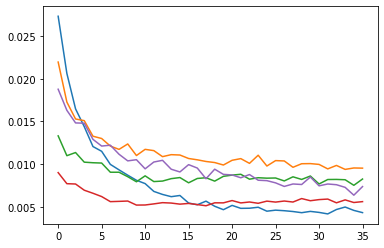

In [18]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(37): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(37):    #2가 맞음 = 바꾸지 말기   
    
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        if global_epoch > 0:
            globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.03627085, 0.057295162, 0.07435926, 0.08692168, 0.09750976, 0.105577335, 0.11267964, 0.1183931, 0.12324124, 0.12750414, 0.13166279, 0.13529569, 0.13880724, 0.1415587, 0.14493838, 0.14812613, 0.15094699, 0.15378872, 0.15647982, 0.15940446, 0.16142856, 0.16394691, 0.16656344, 0.16911778, 0.17116469, 0.17353275, 0.17557247, 0.17707497, 0.17871186, 0.18048786, 0.18229859, 0.18370144, 0.18545546, 0.18730092, 0.18861035, 0.18990201, 0.19133967]
[0.033089753, 0.04627946, 0.05681275, 0.065011114, 0.07214442, 0.07818678, 0.08391946, 0.088965446, 0.09244172, 0.097055115, 0.10053646, 0.103939794, 0.10843559, 0.11217422, 0.115959406, 0.119980894, 0.12316358, 0.12652142, 0.12912093, 0.13137607, 0.13431786, 0.13745487, 0.13976018, 0.14132242, 0.14461146, 0.14659321, 0.14938621, 0.1517939, 0.15391332, 0.15631893, 0.15720779, 0.15889174, 0.1599985, 0.16227342, 0.16364494, 0.165

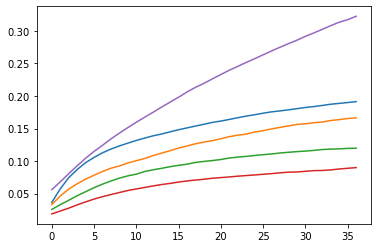

In [15]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(37): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(37):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

[[0.7767776846885681, 0.8181818127632141, 0.8145814538002014, 0.7947794795036316, 0.7983798384666443, 0.82268226146698, 0.8100810050964355, 0.7965796589851379, 0.8100810050964355], [0.8154815435409546, 0.7632763385772705, 0.7641764283180237, 0.786678671836853, 0.801980197429657, 0.8010801076889038, 0.7785778641700745, 0.7425742745399475, 0.7695769667625427], [0.8136813640594482, 0.807380735874176, 0.8082808256149292, 0.8109810948371887, 0.7929793000221252, 0.8361836075782776, 0.8127812743186951, 0.7830783128738403, 0.7857785820960999], [0.8289828896522522, 0.8235823512077332, 0.8343834280967712, 0.8406840562820435, 0.8298829793930054, 0.8505850434303284, 0.8037803769111633, 0.8370836973190308, 0.8307830691337585], [0.8568856716156006, 0.8379837870597839, 0.8379837870597839, 0.8451845049858093, 0.8334833383560181, 0.8478847742080688, 0.8289828896522522, 0.8136813640594482, 0.8154815435409546], [0.8469846844673157, 0.8550854921340942, 0.864086389541626, 0.8442844152450562, 0.839783966541

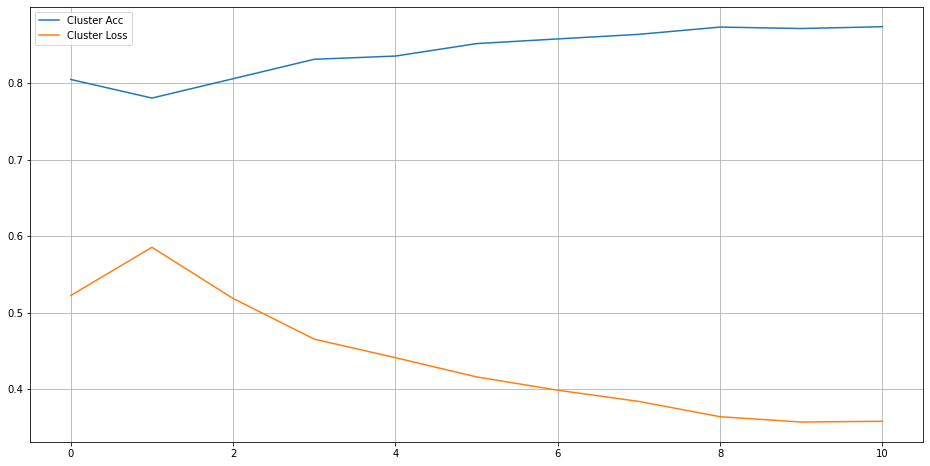

In [20]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS)
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()
